<a href="https://colab.research.google.com/github/juuhcsr/Imersao_vertex_alura/blob/main/Projeto_Alura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto Alura com dados do ENEM**



A ideia do projeto é utilizar os modelos do vertex AI para fazer o processamento com NLP (Linguagem natural) para os dados do **enem de 2022**, assim conectando a base de dados com o vertex AI e gerando os resultados que são utilizados para gerar insights e criar uma dashboard (Acompanhe o final da documentação para ver e acessar o exemplo)

**Objetivo específico: Usar o code colab para gerar sql, executar com a API BigQuery de forma automática e gerar insights para utilizar na criação de dashboards com o looker studio.**


---

# **Conheça mais sobre o projeto**

<details>
<summary> Arquitetura </summary><br/>

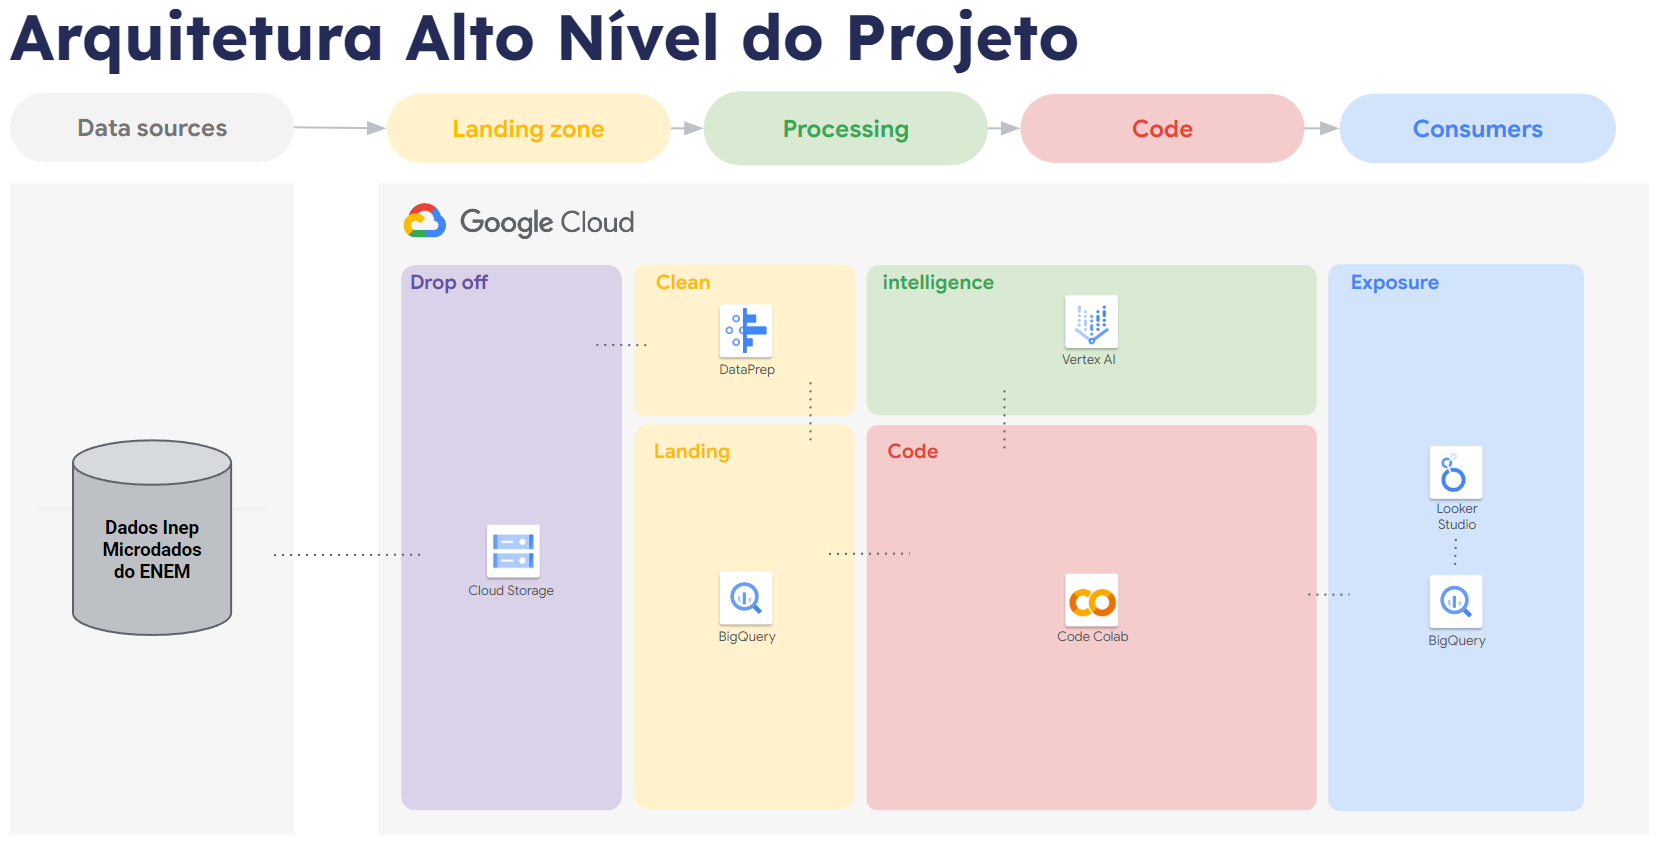

Serviços utilizados

|   Serviço    |                    Motivo de Uso                       |
|--------------|---------------------------------------------------------|
| Dados INEP   | O inep disponibiliza [microdados](https://https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados) do ENEM e de outras fontes |
| Cloud Storage| Armazenar e gerenciar dados brutos |
|   DataPrep   | Preparar e limpar dados para análise aqui podemos conhecer nossos dados|
|   BigQuery   | Armazenar e analisar grandes conjuntos de dados         |
|  Code Colab  | Executar notebooks e código Python, aqui criamos toda a lógica do projeto. |
|  Vertex AI   | Os modelos utilizados no codecolab são disponibilizados pelo Vertex          |
|    Looker  Studio     | Visualizar e analisar dados de forma interativa  |


<br>


---


</details>

<details>
<summary> Conheça mais a fundo o projeto </summary><br/>

Esse projeto fez parte a Imersão alura que aconteceu na segunda semana de maio e teve como objetivo principal apresentar o ai studio do google e o colab, o ai studio é uma ferramenta para criar e testar prompts e gerar chatbots multimodais. O colab é uma ferramenta interativa para criar códigos python.

Na fase inicial a ideia desse projeto era exportar os dados para um dataframe e depois para o google planilhas mas acabei deixando essa ideia de lado por não conhecer muito bem sobre essas ferramentas, esse foi o meu primeiro projeto de chatbot e a primeira vez que faço integraçoes com a API do Bigquery no colab então deu pra aprender muitas coisas.

As principais dificuldades desse projeto foram:


*   Integração do dataframe com a resposta do chat do GEMINI (não resolvido)
*   Criar os prompts assertivos e evitar ilusões
*   Integrar a lógica de puxar os dados do BigQuery e fazer mais uma consulta em cima dos dados processados
*   Ver o sql Gerado (isso eu resolvi depois de botar a variavel como global)
*   Exaust do modelo (acabei fazendo um for e fiquei quase uma hora sem poder usar a API do vertex)

As coisas que mais considero que aprendi foram:

 * Como Aplicar na prática o Chain of thought e Few Shots prompt
 * Como fazer integrações de python com o BigQuery
 * Como usar o ai studio (via muito ele nos cursos mas nunca tinha utilizado)
 * Como funcionam os dataframes do panda (apesar de não ter consigo integrar eu aprendi muito errando)
 * Como funcionam embeddings


---
</details>

<details>
<summary> Como Utilizar </summary><br/>

Para utilizar esse projeto, você precisa fazer algumas tarefas:


1.   Configurar os secrets
2.   Importar a tabela para o Bigquery
3.   Configurar o prompt para criar SQL baseado na sua tabela
4.   Testar, melhorar e implementar mais

A dashboard baseada nos insights é pública e assesível por esse link:



---
</details>


<details>
<summary> Sobre o autor </summary><br/>

Olá, meu nome é júlio tenho 20 anos, esse é o meu [linkedin](https://www.linkedin.com/in/julio-ferrer/) me manda um invite e vamos trocar ideia. Apesar de eu ter conseguido várias certificações no GCP não tenho muita experiência prática e esse tipo de imersão ajuda a gente a pegar vários insights legais.
Se quiser, a gente pode jogar alguma coisa também tipo um lolzinho ou um cs.
Sempre fui apaixonado e muito curioso pela tecnologia e desde que ingressei no mercado de trabalho me apaixonei pela área de dados. estou terminando minha primeira faculdade (acabo final do ano) e estou pensando em fazer mais uma.


---
</details>



---


# Código do projeto

## Instalando depêndencias e importação de variáveis

vamos instalar os pacotes referente ao google planilhas e ao generative ai  

In [211]:
!pip install -q -U google-generativeai
!pip install gspread

Depois de instalar os pacotes, fazemos a importação dos módulos utilizados


*   Genai;
*   Dados do colab (api_key);
*   Autenticação;
*   Bigquery;

e por último mas não menos importante configuramos a API_key


In [212]:
import google.generativeai as genai
from google.colab import userdata
from google.colab import auth
from google.cloud import bigquery
from google.auth import default

#Configuração da API_key
api_key = userdata.get('SECRET_KEY')
genai.configure(api_key=api_key)

# Autenticar usuário
auth.authenticate_user()

# Configure a secret PROJECT_ID
projeto = userdata.get('PROJECT_ID')
project_id = projeto
client = bigquery.Client(project=project_id)

## Configuração do modelo

Listando todos os modelos de geração de conteúdo

In [213]:
for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

models/gemini-1.0-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro-vision-latest
models/gemini-1.5-pro-latest
models/gemini-pro
models/gemini-pro-vision


Configurando a temperatura o a segurança do modelo

In [217]:
generation_config = {
  "temperature": 0.94,
}
safety_settings = {
    "HARASSMENT":"BLOCK_ONLY_HIGH",
    "HATE":"BLOCK_ONLY_HIGH",
    "SEXUAL":"BLOCK_ONLY_HIGH",
    "DANGEROUS":"BLOCK_ONLY_HIGH"
}

Definição do modelo

In [218]:
model = genai.GenerativeModel(model_name="gemini-1.5-pro-latest",
                              generation_config=generation_config,
                              safety_settings=safety_settings)

Aqui é só um teste do generative ai mesmo, mantive porque achei legal a história que o gemini criou 🙂 (mais tarde eu tive um insight muito louco por
causa *disso*)

In [ ]:
response=model.generate_content("Write a history about a minecraft villager who sells weapons and discover that him is a special villager with magic powers")
print(response.text)

## Configurando o chatbot

Na etapa de configuração do menu, decidi deixar um pouco mais agradável assim ao invés de poluir a tela você decide se quer ver ou não a consulta que foi gerada

In [219]:
#Configurando o menu

# Função para ver a query SQL gerada
def opcao_1():

    print("=================================")
    print(" O sql gerado pelo modelo foi: \n")
    print ("resposta: \n ", consulta , "\n" )
    print("=================================")

#Função para executar o prompt, fazer a query SQL e gerar o prompt baseado na resposta
def opcao_2():

    # Fazendo a pergunta para gerar o SQL
    prompt = input("Esperando Prompt: \n")
    response = chat.send_message(prompt)
    global consulta
    consulta=f"{response.text}"

    # Fazendo a consulta com a API do BigQuery
    query_job = client.query(consulta)
    result= ""
    result = query_job.result()

    # Obtendo o resultado da consulta e agregando para o novo prompt
    acumulado =[]
    for row in query_job:
        resposta = row
        acumulado.append(resposta)

    #Novo propt com os dados acumulados, nessa hora eu tinha colocado um for e cada resultado gerava um prompt o que exaustou a API do vertex (foi um pouco desesperador)
    promptx = f"""
    1.Receber os dados de tupla que vieram de uma consulta do bigquery
    2. Converta dados baseado no dicionário de dados enviados, ao invés de 1,2,3,4... converta o significado desse dado
    3.Ver a possibilidade de fazer um markdown e entregar esse resultado em uma tabela com uma explicação:
      a.Se for uma resposta única, responda ela
      b.Se tiver diversas saídas, responda em uma tabela formatada
    4. Concentre-se em responder à pergunta do usuário de forma clara, concisa e direta.

    utilize essa resposta para gerar a sua resposta: {acumulado}
    """
    global response2x
    response2=model.generate_content(promptx)
    response2x=response2.text
    print(response2.text)

#Para execução
def opcao_3():
    print("Parando execução")
    return "exit"

#Configuração do Menu
def switch_case(opcao):
    switch = {
        1: opcao_1,
        2: opcao_2,
        3: opcao_3    }
    return switch.get(opcao, lambda: print("Opção inválida"))()

## Configurando o PDF de dicionário de dados - acessível pelo site do INEP

def extract_pdf_pages(pathname: str) -> list[str]:
  parts = [f"--- START OF PDF ${pathname} ---"]
  pages = []
  for index, page in enumerate(pages):
    parts.append(f"--- PAGE {index} ---")
    parts.append(page)
  return parts



Configurando o histórico para o primeiro prompt.

Esse chatbot funciona com dois prompts


1.   Gera um SQL baseado na pergunta do usuário
2.   Gera uma resposta baseada na saída do SQL



In [220]:
#Exemplos para a geração do SQL
chat = model.start_chat(history=[{
    "role": "user",
    "parts": ["Você é um gerador de SQL que será utilizado para projetos no code colab, sua função é entender a pergunta da pessoa e gerar um código que será utilizado para gerar uma consulta na API do bigquery, sua resposta deve ter o seguinte modelo:\n\nPergunta: Qual a média de notas de matemática para cada estado brasileiro ?\nResposta esperada pelo modelo:\n\n-- Média da nota de matemática para cada estado\nSELECT\nSG_UF_ESC,\nROUND(AVG(NU_NOTA_MT), 2) AS Média_Matemática\nFROM\ngen-lang-client-0906472213.Dados_enem_2022.Dados_enem\nGROUP BY\nSG_UF_ESC\nLIMIT\n1000\n\nUse o seguinte arquivo como dicionário de dados\n"]
  },
  {
    "role": "user",
    "parts": extract_pdf_pages("<path>/document0.pdf")
  },
  {
    "role": "user",
    "parts": ["\n\nRegras:\n1.o caminho da tabela associada é: `gen-lang-client-0906472213.Dados_enem_2022.Dados_enem`;\n2. A consulta que será gerada será utilizada no Bigquery, não utilize caractéres que não podem ser utilizados;\n3.foi adicionada uma coluna chamada media_total que é a média de notas de todas as competências;\n4.para valores decimais, arredonde para duas casas;\n5.para o título, faça um comentário sql.\n\nvocê entendeu sua tarefa ? Dê exemplos básicos de consultas que você pode executar, sem o código sql."]
  },
  {
    "role": "model",
    "parts": ["Sim, eu entendi a minha tarefa. Serei um gerador de código SQL para consultas na API do BigQuery usando os dados do ENEM 2022, formatando as respostas de acordo com o modelo fornecido. \n\n## Exemplos de consultas que posso executar:\n\n1. **Número de participantes por estado:**  Contar quantos participantes fizeram o ENEM em cada estado brasileiro.\n2. **Média da nota de redação por faixa etária:** Calcular a média da nota da redação para cada faixa etária dos participantes.\n3. **Porcentagem de participantes que se declaram brancos por região:** Calcular a porcentagem de participantes que se autodeclararam brancos em cada região do Brasil.\n4. **Relação entre renda familiar e nota de matemática:** Verificar se existe alguma correlação entre a renda familiar dos participantes e suas notas na prova de matemática. \n5. **Comparar o desempenho de treineiros e vestibulandos:** Analisar as diferenças no desempenho entre os participantes que fizeram a prova como treineiros e aqueles que estavam realmente buscando uma vaga no ensino superior.\n\nEm todos os casos, posso gerar o código SQL completo, formatado de acordo com o modelo, incluindo título, seleção das colunas relevantes, filtros, agrupamentos e limite de linhas."]
  },
  {
    "role": "user",
    "parts": ["compare o desempenho da média geral de treineiros e vestibulandos"]
  },
  {
    "role": "model",
    "parts": ["-- Comparação da média geral de treineiros e vestibulandos\nSELECT\n    IN_TREINEIRO,\n    ROUND(AVG(NU_NOTA_CN), 2) AS Media_CN,\n    ROUND(AVG(NU_NOTA_CH), 2) AS Media_CH,\n    ROUND(AVG(NU_NOTA_LC), 2) AS Media_LC,\n    ROUND(AVG(NU_NOTA_MT), 2) AS Media_MT,\n    ROUND(AVG((NU_NOTA_CN + NU_NOTA_CH + NU_NOTA_LC + NU_NOTA_MT) / 4), 2) AS Media_Total\nFROM\n    `gen-lang-client-0906472213.Dados_enem_2022.Dados_enem`\nGROUP BY\n    IN_TREINEIRO\nLIMIT 1000"]
  },
  {
    "role": "user",
    "parts": ["qual é o estado com maior nota de português ?"]
  },
  {
    "role": "model",
    "parts": ["-- Estado com maior nota média em Linguagens e Códigos (Português)\nSELECT\n  SG_UF_ESC,\n  ROUND(AVG(NU_NOTA_LC), 2) AS Media_LC\nFROM\n  `gen-lang-client-0906472213.Dados_enem_2022.Dados_enem`\nGROUP BY\n  SG_UF_ESC\nORDER BY\n  Media_LC DESC\nLIMIT 1"]
  },
  {
    "role": "user",
    "parts": ["faça uma lista de quantos participantes tiveram em cada estado"]
  },
  {
    "role": "model",
    "parts": ["-- Número de participantes por estado\nSELECT\n  SG_UF_ESC,\n  COUNT(DISTINCT NU_INSCRICAO) AS Numero_Participantes\nFROM\n  `gen-lang-client-0906472213.Dados_enem_2022.Dados_enem`\nGROUP BY\n  SG_UF_ESC\nORDER BY\n  Numero_Participantes DESC\nLIMIT 1000"]
  },
  {
    "role": "user",
    "parts": ["faça uma lista com a média geral de todos os estados do brasil"]
  },
  {
    "role": "model",
    "parts": ["-- Média geral das notas por estado\nSELECT\n    SG_UF_ESC,\n    ROUND(AVG(NU_NOTA_CN), 2) AS Media_CN,\n    ROUND(AVG(NU_NOTA_CH), 2) AS Media_CH,\n    ROUND(AVG(NU_NOTA_LC), 2) AS Media_LC,\n    ROUND(AVG(NU_NOTA_MT), 2) AS Media_MT,\n    ROUND(AVG((NU_NOTA_CN + NU_NOTA_CH + NU_NOTA_LC + NU_NOTA_MT) / 4), 2) AS Media_Total\nFROM\n    `gen-lang-client-0906472213.Dados_enem_2022.Dados_enem`\nGROUP BY\n    SG_UF_ESC\nORDER BY\n  SG_UF_ESC\nLIMIT 1000"]
  },
  {
    "role": "user",
    "parts": ["qual é a porcentagem de brancos em cada estado do brasil ?"]
  },
  {
    "role": "model",
    "parts": ["-- Porcentagem de participantes que se declaram brancos por estado\nSELECT\n  SG_UF_ESC,\n  ROUND(CAST(SUM(CASE WHEN TP_COR_RACA = 1 THEN 1 ELSE 0 END) AS FLOAT64) * 100 / COUNT(*), 2) AS Porcentagem_Brancos\nFROM\n  `gen-lang-client-0906472213.Dados_enem_2022.Dados_enem`\nGROUP BY\n  SG_UF_ESC\nORDER BY\n  Porcentagem_Brancos DESC\nLIMIT 1000"]
  },
  {
    "role": "user",
    "parts": ["qual é a nota de matemática do estado da bahia ?"]
  },
  {
    "role": "model",
    "parts": ["-- Nota média de matemática na Bahia\nSELECT\n  ROUND(AVG(NU_NOTA_MT), 2) AS Media_Matematica_Bahia\nFROM\n  `gen-lang-client-0906472213.Dados_enem_2022.Dados_enem`\nWHERE\n  SG_UF_ESC = 'BA'\nLIMIT 1000"]
  },])

## Executando o menu

### Alguns exemplos de prompts que foram utilizados para criar as dashboards:

 * **Qual é o Número de participantes por estado:** Contar quantos participantes fizeram o ENEM em cada estado brasileiro.
 * **Qual é a Média da nota de redação por faixa etária:** Calcular a média da nota da redação para cada faixa etária dos participantes.
 * **Qual é a nota específica de cada área e a média geral das notas de cada estado:** Calcular a média de cada nota de cada estado e a média geral
 * **Qual é % de participação de cada tipo de escola:** Verifica a participação de escolar públicas e particulares
 * **Compare o desempenho de treineiros e vestibulandos em relação a todas as notas:** Analisar as diferenças no desempenho entre os participantes que fizeram a prova como treineiros e aqueles que estavam realmente buscando uma vaga no ensino superior.

In [222]:
opcao_2()

while True:
  print("-------------------------------")
  print("Escolha uma opção:")
  print("1. Ver o SQL gerado")
  print("2. Fazer outra pergunta")
  print("3. Sair")
  print("-------------------------------")
  escolha = int(input("Digite o número da opção desejada: \n"))

  switch_case(escolha)

  if escolha == 3:
      break

Esperando Prompt: 
Qual é a nota específica de cada área e a média geral das notas de cada estado
## Médias do ENEM por Estado

A tabela abaixo apresenta as médias por estado em cada área do conhecimento no ENEM: Ciências da Natureza (CN), Ciências Humanas (CH), Linguagens e Códigos (LC), Matemática (MT) e a média total.

| Estado | Média CN | Média CH | Média LC | Média MT | Média Total |
|---|---|---|---|---|---|
|   | 495.26 | 527.27 | 517.82 | 540.11 | 521.46 |
| AC | 477.93 | 502.39 | 490.57 | 510.74 | 497.38 |
| AL | 487.43 | 510.41 | 499.0 | 530.18 | 508.27 |
| AM | 471.68 | 490.21 | 481.22 | 494.11 | 486.91 |
| AP | 474.33 | 502.42 | 489.57 | 496.84 | 492.52 |
| BA | 492.9 | 520.96 | 509.35 | 533.91 | 515.85 |
| CE | 474.31 | 491.96 | 479.83 | 507.79 | 490.24 |
| DF | 510.41 | 542.03 | 538.89 | 559.52 | 539.1 |
| ES | 504.97 | 537.31 | 522.99 | 562.76 | 533.55 |
| GO | 492.14 | 518.43 | 507.21 | 537.69 | 516.03 |
| MA | 474.55 | 492.99 | 479.43 | 503.71 | 489.05 |
| MG | 516.46

### Lógica por trás do chatbot

A lógica que pensei pra criar o chatbot é mais ou menos assim:

1. Consulta: O usuário faz uma pergunta.

2. Entendimento: O modelo entende o que o usuário está perguntando e traduz para uma linguagem que o BigQuery compreende (SQL).

3. Busca: O BigQuery é usado para executar a consulta.

4. Resposta: O modelo organiza a resposta do BigQuery e a apresenta ao usuário

5. O modelo Salva a resposta em um dataframe e envia para o google sheets (Não aplicado)

6. O usuário usa os dados salvos e insights obtidos para criar dashboards

> A melhor prática e mais recomendavel seria executar a consulta (com um limit maior) no BigQuery e fazer as dashs a partir do BQ, o Looker Studio tem uma funcionalidade de cache e funciona muito melhor com os dados nessa plataforma. mas eu queria me desafiar a fazer ambas coisas.






Carregando os módulos BigQuery e definindo variáveis



## Resultados Obtidos

Sobre os resultados obtidos:



*   O modelo gera a partir de uma pergunta o resultado e gera um insight
*   Esse insight é utilizado para criar uma dashboard com os dados

[LINK DA DASHBOARD](https://lookerstudio.google.com/reporting/cf5687ea-7577-4c7f-8560-07623abc4315)



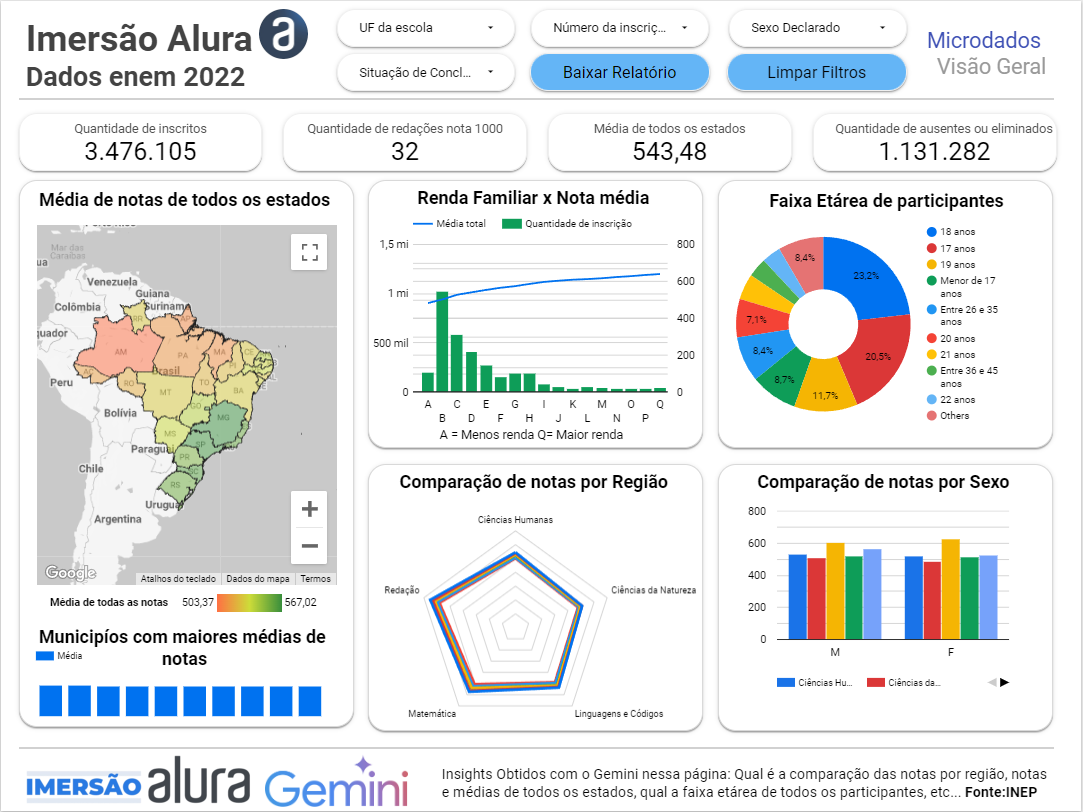